# Stock Price Prediction using Time Series Analysis

## Project Overview
This project implements advanced time series forecasting models to predict stock prices and analyze market trends. We'll use multiple algorithms including ARIMA, LSTM Networks, and Prophet models.

### Dataset Sources:
- **Yahoo Finance API** (via yfinance)
- **Kaggle Stock Market Datasets**
- **Alpha Vantage API**

### Goals:
1. Multi-step ahead stock price prediction
2. Technical indicator integration
3. Risk assessment and portfolio optimization
4. Interactive visualization dashboard

## 1. Library Imports and Setup

In [38]:
!pip install ta-lib ta pmdarima

In [39]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Financial data
import yfinance as yf
# !pip install yfinance ta-lib

# Technical Analysis
import talib
from ta import add_all_ta_features
from ta.utils import dropna

# Time Series Analysis
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from prophet import Prophet

# Machine Learning
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU
from tensorflow.keras.optimizers import Adam

# Visualization
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Style settings
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("All libraries imported successfully!")

All libraries imported successfully!


## 2. Data Collection and Preprocessing

In [40]:
# Define stock symbols for analysis
STOCKS = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'TSLA', 'NVDA', 'META', 'NFLX']
START_DATE = '2019-01-01'
END_DATE = '2024-08-01'

def download_stock_data(symbols, start_date, end_date):
    """Download stock data for given symbols"""
    stock_data = {}
    
    for symbol in symbols:
        try:
            data = yf.download(symbol, start=start_date, end=end_date, progress=False)
            stock_data[symbol] = data
            print(f"Downloaded data for {symbol}: {len(data)} rows")
        except Exception as e:
            print(f"Error downloading {symbol}: {e}")
    
    return stock_data

# Download data
print("Downloading stock data...")
stock_data = download_stock_data(STOCKS, START_DATE, END_DATE)

# Focus on Apple (AAPL) for detailed analysis
df = stock_data['AAPL'].copy()
print(f"\nApple stock data shape: {df.shape}")
print(f"Date range: {df.index.min().strftime('%Y-%m-%d')} to {df.index.max().strftime('%Y-%m-%d')}")

df.head()

Downloaded data for AAPL: 1404 rows
Downloaded data for GOOGL: 1404 rows
Downloaded data for MSFT: 1404 rows
Downloaded data for AMZN: 1404 rows
Downloaded data for TSLA: 1404 rows
Downloaded data for NVDA: 1404 rows
Downloaded data for META: 1404 rows
Downloaded data for NFLX: 1404 rows

Apple stock data shape: (1404, 5)
Date range: 2019-01-02 to 2024-07-31


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2019-01-02,37.575199,37.796484,36.697207,36.854247,148158800
2019-01-03,33.832447,34.672369,33.787238,34.258355,365248800
2019-01-04,35.276730,35.345734,34.215527,34.389221,234428400
2019-01-07,35.198204,35.412351,34.715190,35.381418,219111200
2019-01-08,35.869183,36.123778,35.338581,35.586036,164101200


In [41]:
# Data preprocessing and feature engineering
def preprocess_stock_data(df):
    """Preprocess stock data and add features"""
    
    # FIX: Flatten columns if they are a multi-index from yfinance
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    
    # Basic price features
    df['Returns'] = df['Close'].pct_change()
    df['Log_Returns'] = np.log(df['Close'] / df['Close'].shift(1))
    df['Price_Range'] = df['High'] - df['Low']
    df['Price_Change'] = df['Close'] - df['Open']

    # Moving averages
    for window in [5, 10, 20, 50, 200]:
        df[f'MA_{window}'] = df['Close'].rolling(window=window).mean()
        df[f'EMA_{window}'] = df['Close'].ewm(span=window).mean()

    # Volatility measures
    df['Volatility_10'] = df['Returns'].rolling(window=10).std()
    df['Volatility_30'] = df['Returns'].rolling(window=30).std()

    # Technical indicators using TA-Lib
    # Explicitly convert data to float type for TA-Lib
    close_prices = df['Close'].astype(float).values
    high_prices = df['High'].astype(float).values
    low_prices = df['Low'].astype(float).values
    
    df['RSI'] = talib.RSI(close_prices, timeperiod=14)
    df['MACD'], df['MACD_Signal'], df['MACD_Hist'] = talib.MACD(close_prices)
    df['BB_Upper'], df['BB_Middle'], df['BB_Lower'] = talib.BBANDS(close_prices, timeperiod=20)
    df['Stoch_K'], df['Stoch_D'] = talib.STOCH(high_prices, low_prices, close_prices)
    df['Williams_R'] = talib.WILLR(high_prices, low_prices, close_prices)
    df['ATR'] = talib.ATR(high_prices, low_prices, close_prices, timeperiod=14)
    df['ADX'] = talib.ADX(high_prices, low_prices, close_prices, timeperiod=14)

    # Support and resistance levels
    df['Support'] = df['Low'].rolling(window=20).min()
    df['Resistance'] = df['High'].rolling(window=20).max()

    # Lag features
    for lag in [1, 2, 3, 5, 10]:
        df[f'Close_lag_{lag}'] = df['Close'].shift(lag)
        df[f'Volume_lag_{lag}'] = df['Volume'].shift(lag)

    return df

# Preprocess the data
df = preprocess_stock_data(df)
print(f"Preprocessed data shape: {df.shape}")
print(f"Features added: {df.shape[1] - 6} (original had 6 columns)")

Preprocessed data shape: (1404, 45)
Features added: 39 (original had 6 columns)


## 3. Exploratory Data Analysis

In [42]:
# Interactive price chart with technical indicators
fig = make_subplots(
    rows=4, cols=1,
    subplot_titles=('Stock Price with Moving Averages', 'Volume', 'RSI', 'MACD'),
    vertical_spacing=0.1,
    row_heights=[0.5, 0.2, 0.15, 0.15]
)

# Price and moving averages
fig.add_trace(go.Scatter(x=df.index, y=df['Close'], name='Close Price', line=dict(color='blue')), row=1, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df['MA_20'], name='MA 20', line=dict(color='red')), row=1, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df['MA_50'], name='MA 50', line=dict(color='green')), row=1, col=1)

# Volume
fig.add_trace(go.Bar(x=df.index, y=df['Volume'], name='Volume', marker_color='lightblue'), row=2, col=1)

# RSI
fig.add_trace(go.Scatter(x=df.index, y=df['RSI'], name='RSI', line=dict(color='purple')), row=3, col=1)
fig.add_hline(y=70, line_dash="dash", line_color="red", row=3, col=1)
fig.add_hline(y=30, line_dash="dash", line_color="green", row=3, col=1)

# MACD
fig.add_trace(go.Scatter(x=df.index, y=df['MACD'], name='MACD', line=dict(color='orange')), row=4, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df['MACD_Signal'], name='Signal', line=dict(color='red')), row=4, col=1)

fig.update_layout(height=800, title_text="AAPL Stock Analysis Dashboard", showlegend=True)
fig.show()

# Statistical summary
print("Stock Statistics:")
print(f"Total trading days: {len(df)}")
print(f"Average daily return: {df['Returns'].mean():.4f} ({df['Returns'].mean()*252:.2%} annualized)")
print(f"Volatility: {df['Returns'].std():.4f} ({df['Returns'].std()*np.sqrt(252):.2%} annualized)")
print(f"Max drawdown: {(df['Close'] / df['Close'].expanding().max() - 1).min():.2%}")
print(f"Sharpe ratio: {(df['Returns'].mean() / df['Returns'].std() * np.sqrt(252)):.2f}")

Stock Statistics:
Total trading days: 1404
Average daily return: 0.0015 (36.79% annualized)
Volatility: 0.0199 (31.52% annualized)
Max drawdown: -31.43%
Sharpe ratio: 1.17


## 4. Time Series Decomposition and Stationarity Test

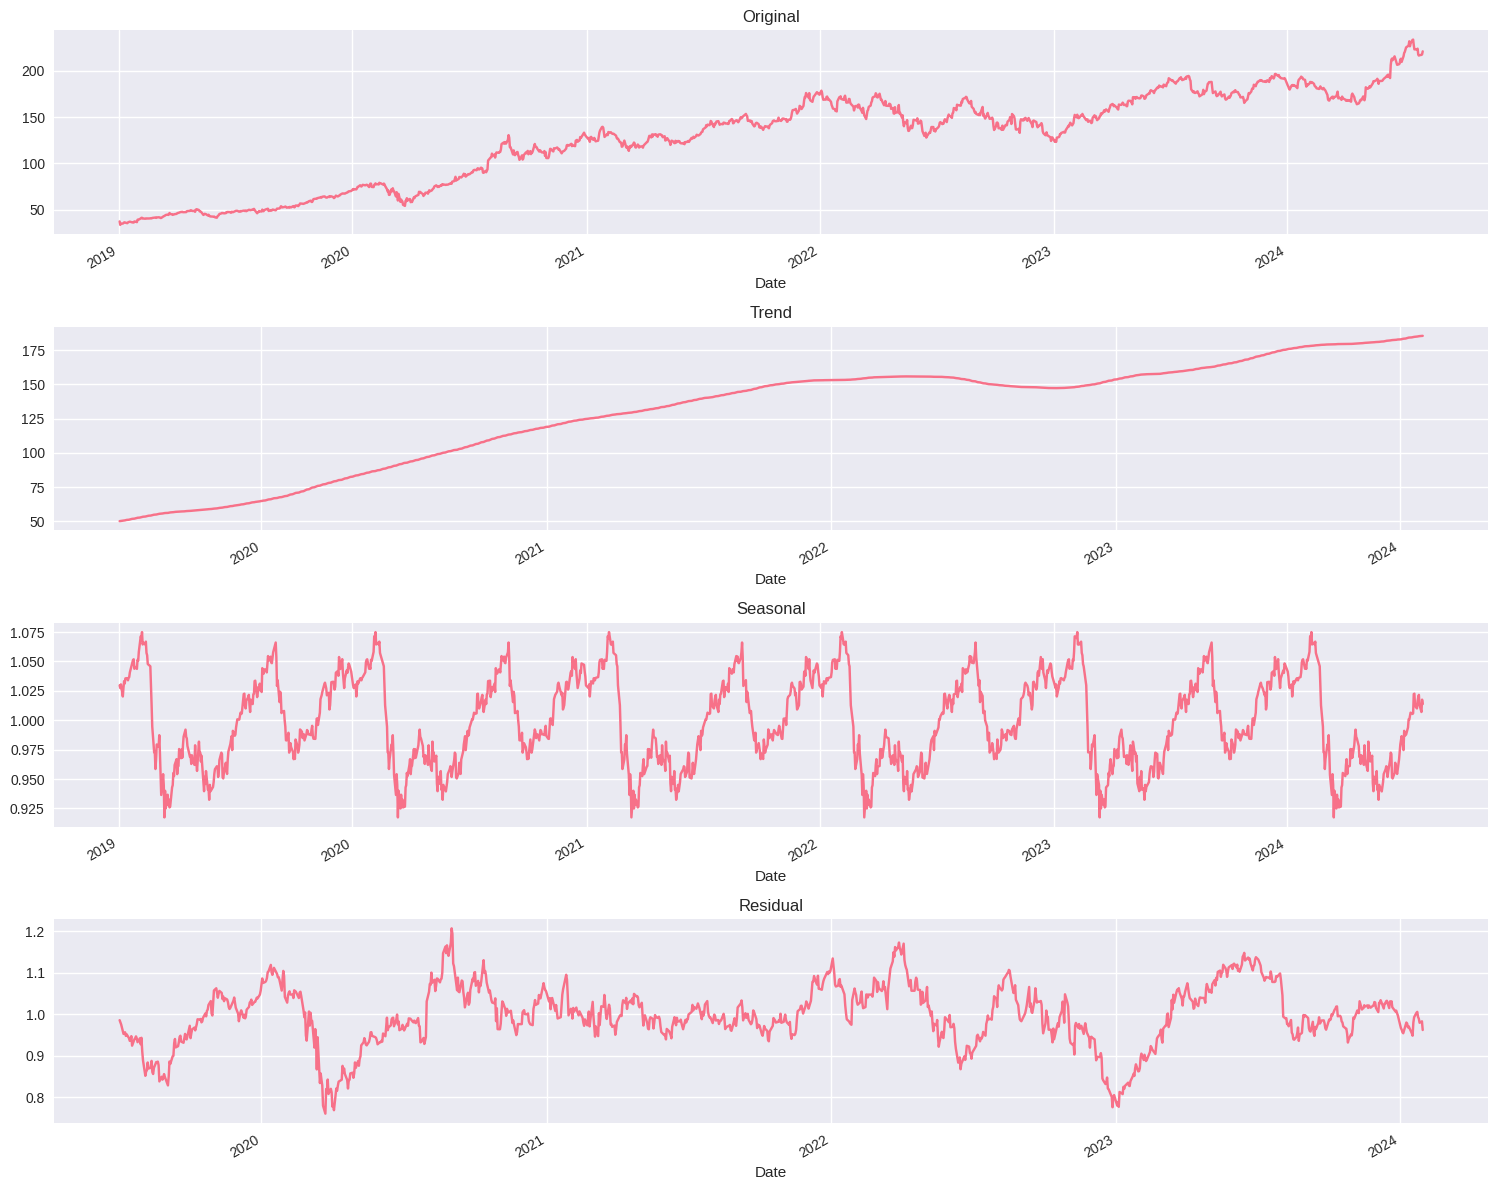


Stock Price:
ADF Statistic: -0.859055
p-value: 0.801157
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
Result: Series is non-stationary

Returns:
ADF Statistic: -11.865438
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
Result: Series is stationary

Log Returns:
ADF Statistic: -11.788286
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
Result: Series is stationary


In [43]:
# Time series decomposition
decomposition = seasonal_decompose(df['Close'].dropna(), model='multiplicative', period=252)  # Annual seasonality

fig, axes = plt.subplots(4, 1, figsize=(15, 12))
decomposition.observed.plot(ax=axes[0], title='Original')
decomposition.trend.plot(ax=axes[1], title='Trend')
decomposition.seasonal.plot(ax=axes[2], title='Seasonal')
decomposition.resid.plot(ax=axes[3], title='Residual')
plt.tight_layout()
plt.show()

# Stationarity tests
def check_stationarity(timeseries, title):
    """Check stationarity using Augmented Dickey-Fuller test"""
    result = adfuller(timeseries.dropna())
    print(f'\n{title}:')
    print(f'ADF Statistic: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.3f}')
    
    if result[1] <= 0.05:
        print("Result: Series is stationary")
    else:
        print("Result: Series is non-stationary")
    return result[1] <= 0.05

# Test stationarity
is_stationary_price = check_stationarity(df['Close'], 'Stock Price')
is_stationary_returns = check_stationarity(df['Returns'], 'Returns')
is_stationary_log_returns = check_stationarity(df['Log_Returns'], 'Log Returns')

## 5. ARIMA Model Implementation

In [44]:
# Prepare data for ARIMA (use returns as they are more stationary)
returns_clean = df['Returns'].dropna()

# Auto ARIMA to find best parameters
print("Finding optimal ARIMA parameters...")
auto_arima_model = pm.auto_arima(returns_clean, 
                                 start_p=0, start_q=0,
                                 max_p=5, max_q=5,
                                 seasonal=False,
                                 stepwise=True,
                                 suppress_warnings=True,
                                 error_action='ignore')

print(f"Optimal ARIMA order: {auto_arima_model.order}")
print(auto_arima_model.summary())

# Split data for training and testing
train_size = int(len(returns_clean) * 0.8)
train_returns = returns_clean[:train_size]
test_returns = returns_clean[train_size:]

# Fit ARIMA model
arima_model = ARIMA(train_returns, order=auto_arima_model.order)
arima_fitted = arima_model.fit()

# Make predictions
arima_forecast = arima_fitted.forecast(steps=len(test_returns))
arima_forecast_ci = arima_fitted.get_forecast(steps=len(test_returns)).conf_int()

# Convert return predictions back to price predictions
# FIX: Use the last date index from the training returns to get the correct starting price
last_price = df.loc[train_returns.index[-1], 'Close']
arima_price_forecast = [last_price]

for i, return_pred in enumerate(arima_forecast):
    next_price = arima_price_forecast[-1] * (1 + return_pred)
    arima_price_forecast.append(next_price)

arima_price_forecast = np.array(arima_price_forecast[1:])  # Remove initial price

# Evaluate ARIMA model
test_prices = df['Close'].iloc[train_size+1:].values
arima_rmse = np.sqrt(mean_squared_error(test_prices, arima_price_forecast))
arima_mae = mean_absolute_error(test_prices, arima_price_forecast)
arima_mape = np.mean(np.abs((test_prices - arima_price_forecast) / test_prices)) * 100

print(f"\nARIMA Model Performance:")
print(f"RMSE: ${arima_rmse:.2f}")
print(f"MAE: ${arima_mae:.2f}")
print(f"MAPE: {arima_mape:.2f}%")

Finding optimal ARIMA parameters...
Optimal ARIMA order: (1, 0, 0)
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1403
Model:               SARIMAX(1, 0, 0)   Log Likelihood                3517.761
Date:                Sun, 17 Aug 2025   AIC                          -7029.523
Time:                        11:20:33   BIC                          -7013.783
Sample:                             0   HQIC                         -7023.640
                               - 1403                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0016      0.001      3.087      0.002       0.001       0.003
ar.L1         -0.1139      0.017     -6.773      0.000      -0.1

## 6. LSTM Neural Network Implementation

In [45]:
# Prepare data for LSTM
def create_lstm_dataset(data, time_steps=60):
    """Create dataset for LSTM training"""
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i])
        y.append(data[i])
    return np.array(X), np.array(y)

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1, 1))

# Create sequences
TIME_STEPS = 60
X, y = create_lstm_dataset(scaled_data.flatten(), TIME_STEPS)

# Split data
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape for LSTM [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print(f"LSTM Training data shape: {X_train.shape}")
print(f"LSTM Testing data shape: {X_test.shape}")

LSTM Training data shape: (1075, 60, 1)
LSTM Testing data shape: (269, 60, 1)


In [46]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# --- Enhanced LSTM Model Architecture ---
print("🧠 Building Enhanced Stacked LSTM Model...")
time_step = 60

# Define the enhanced stacked LSTM model
lstm_model = Sequential([
    # First LSTM layer with return_sequences=True to feed the next layer
    LSTM(100, return_sequences=True, input_shape=(time_step, 1)),
    Dropout(0.2),
    # Second LSTM layer
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    # Dense layers for output
    Dense(25),
    Dense(1)
])

# Compile the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.summary()

# --- Train the Enhanced LSTM Model ---
print("\\n🔥 Training Enhanced LSTM Model...")
history = lstm_model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=64,
    verbose=1
)

# --- Evaluate the Enhanced LSTM Model ---
print("\\n📈 Evaluating Enhanced LSTM Model...")
lstm_predictions = lstm_model.predict(X_test)

# Inverse transform the predictions and actuals to get the real price values
lstm_predictions = scaler.inverse_transform(lstm_predictions)
y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
lstm_rmse = np.sqrt(mean_squared_error(y_test_unscaled, lstm_predictions))
lstm_mae = mean_absolute_error(y_test_unscaled, lstm_predictions)
lstm_mape = np.mean(np.abs((y_test_unscaled - lstm_predictions) / y_test_unscaled)) * 100
lstm_r2 = r2_score(y_test_unscaled, lstm_predictions)

print(f"\\nEnhanced LSTM Performance:")
print(f"RMSE: ${lstm_rmse:.2f}")
print(f"MAE: ${lstm_mae:.2f}")
print(f"MAPE: {lstm_mape:.2f}%")
print(f"R²: {lstm_r2:.4f}")

🧠 Building Enhanced Stacked LSTM Model...


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 60, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 72,301 (282.43 KB)

 Trainable params: 72,301 (282.43 KB)

 Non-trainable params: 0 (0.00 B)

\n🔥 Training Enhanced LSTM Model...
Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0765 - val_loss: 0.0249
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0063 - val_loss: 0.0103
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0039 - val_loss: 0.0022
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0024 - val_loss: 0.0010
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0023 - val_loss: 9.9417e-04
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0020 - val_loss: 0.0010
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0021 - val_loss: 9.6923e-04
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 9/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0020 - val_loss: 9.4210e-04
Epoch 10/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 11/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0022 - val_loss: 9.6839e-04
Epoch 12/50

## 7. Prophet Model Implementation

11:20:50 - cmdstanpy - INFO - Chain [1] start processing


Training Prophet model...


11:20:51 - cmdstanpy - INFO - Chain [1] done processing



Prophet Model Performance:
RMSE: $20.29
MAE: $15.64
MAPE: 8.00%
R²: -0.8328


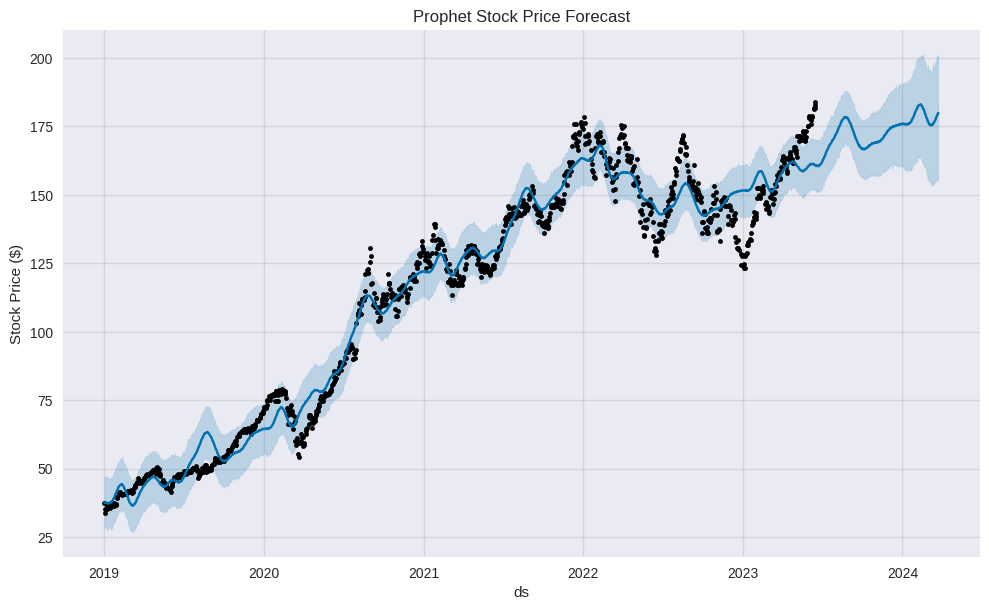

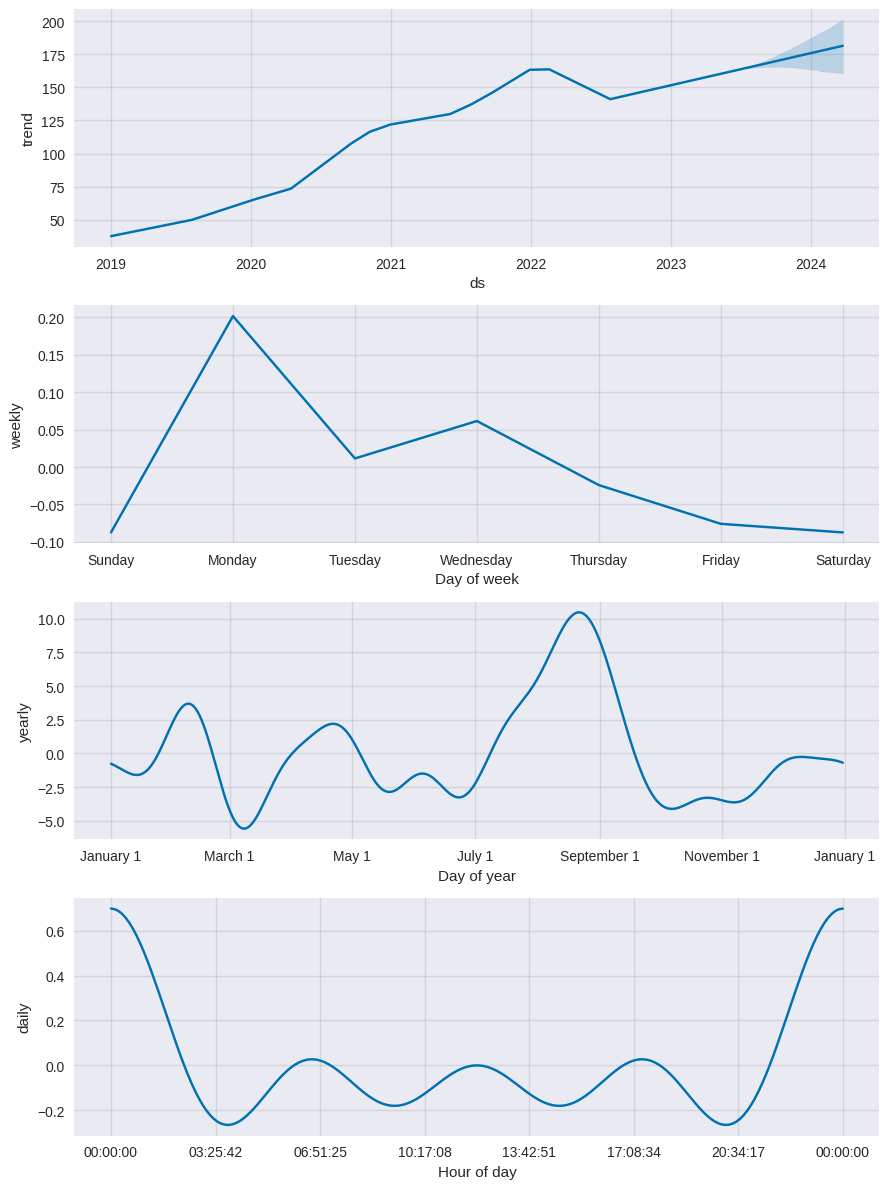

In [47]:
# Prepare data for Prophet
prophet_data = df[['Close']].reset_index()
prophet_data.columns = ['ds', 'y']
prophet_data = prophet_data.dropna()

# Split data
train_size_prophet = int(len(prophet_data) * 0.8)
train_prophet = prophet_data[:train_size_prophet]
test_prophet = prophet_data[train_size_prophet:]

# Create and fit Prophet model
prophet_model = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True,
    changepoint_prior_scale=0.05,
    seasonality_prior_scale=10.0
)

print("Training Prophet model...")
prophet_model.fit(train_prophet)

# Make future predictions
future = prophet_model.make_future_dataframe(periods=len(test_prophet))
prophet_forecast = prophet_model.predict(future)

# Extract test predictions
prophet_predictions = prophet_forecast['yhat'].iloc[-len(test_prophet):].values
prophet_actual = test_prophet['y'].values

# Evaluate Prophet model
prophet_rmse = np.sqrt(mean_squared_error(prophet_actual, prophet_predictions))
prophet_mae = mean_absolute_error(prophet_actual, prophet_predictions)
prophet_mape = np.mean(np.abs((prophet_actual - prophet_predictions) / prophet_actual)) * 100
prophet_r2 = r2_score(prophet_actual, prophet_predictions)

print(f"\nProphet Model Performance:")
print(f"RMSE: ${prophet_rmse:.2f}")
print(f"MAE: ${prophet_mae:.2f}")
print(f"MAPE: {prophet_mape:.2f}%")
print(f"R²: {prophet_r2:.4f}")

# Plot Prophet forecast
fig = prophet_model.plot(prophet_forecast)
plt.title('Prophet Stock Price Forecast')
plt.ylabel('Stock Price ($)')
plt.show()

# Plot components
fig = prophet_model.plot_components(prophet_forecast)
plt.show()

## 8. Ensemble Methods and XGBoost

In [48]:
# Prepare features for ensemble models
feature_columns = ['Open', 'High', 'Low', 'Volume', 'Returns', 'MA_5', 'MA_10', 'MA_20', 
                   'EMA_10', 'RSI', 'MACD', 'BB_Upper', 'BB_Lower', 'Stoch_K', 'ATR',
                   'Close_lag_1', 'Close_lag_2', 'Close_lag_3', 'Volume_lag_1', 'Volatility_10']

# Create feature matrix by dropping rows with NaNs from feature engineering
ml_df = df[feature_columns + ['Close']].dropna()

# FIX: Renaming variables to avoid conflict with LSTM data
X_ml = ml_df[feature_columns]
y_ml = ml_df['Close']

# Split data using a temporal split (80% train, 20% test)
train_size_ml = int(len(X_ml) * 0.8)
X_train_ml, X_test_ml = X_ml[:train_size_ml], X_ml[train_size_ml:]
y_train_ml, y_test_ml = y_ml[:train_size_ml], y_ml[train_size_ml:]

# Scale features
feature_scaler = StandardScaler()
X_train_scaled = feature_scaler.fit_transform(X_train_ml)
X_test_scaled = feature_scaler.transform(X_test_ml)

print(f"Feature matrix shape: {X_ml.shape}")
print(f"Training set: {X_train_ml.shape}")
print(f"Testing set: {X_test_ml.shape}")

Feature matrix shape: (1371, 20)
Training set: (1096, 20)
Testing set: (275, 20)


In [49]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

# --- Hyperparameter Tuning for XGBoost ---
# Prepare data for ML models (remove NaNs from feature engineering)
df_ml = df.dropna()
X_for_xgb = df_ml.drop('Close', axis=1)
y_for_xgb = df_ml['Close']

# Use a temporal split for time series data
split_idx = int(len(df_ml) * 0.8)
X_train_xgb, X_test_xgb = X_for_xgb[:split_idx], X_for_xgb[split_idx:]
y_train_xgb, y_test_xgb = y_for_xgb[:split_idx], y_for_xgb[split_idx:]


print("🚀 Performing Hyperparameter Tuning for XGBoost...")

# Define the parameter grid to search
param_grid = {
    'n_estimators': [500, 1000],
    'max_depth': [5, 7],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 0.9]
}

# Initialize the XGBoost regressor
xgb_for_tuning = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

# FIX: Use TimeSeriesSplit for correct cross-validation with time-series data
tscv = TimeSeriesSplit(n_splits=3)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_for_tuning,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=tscv,
    verbose=1
)

# Fit the grid search to the data
grid_search.fit(X_train_xgb, y_train_xgb)

# Get the best parameters
best_xgb_params = grid_search.best_params_
print(f"\\n✅ Best XGBoost Parameters found: {best_xgb_params}")

🚀 Performing Hyperparameter Tuning for XGBoost...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
\n✅ Best XGBoost Parameters found: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.8}


In [50]:
# Initialize and train XGBoost model with the best parameters
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', 
                             random_state=42, 
                             n_jobs=-1, 
                             **best_xgb_params)

print("\\nTraining XGBoost model...")
xgb_model.fit(X_train_xgb, y_train_xgb, 
              eval_set=[(X_test_xgb, y_test_xgb)], 
              early_stopping_rounds=50, 
              verbose=False)

# Make predictions
xgb_predictions = xgb_model.predict(X_test_xgb)

# Evaluate XGBoost model
xgb_rmse = np.sqrt(mean_squared_error(y_test_xgb, xgb_predictions))
xgb_mae = mean_absolute_error(y_test_xgb, xgb_predictions)
xgb_mape = np.mean(np.abs((y_test_xgb - xgb_predictions) / y_test_xgb)) * 100

print(f"\\nXGBoost Model Performance:")
print(f"RMSE: ${xgb_rmse:.2f}")
print(f"MAE: ${xgb_mae:.2f}")
print(f"MAPE: {xgb_mape:.2f}%")

\nTraining XGBoost model...
\nXGBoost Model Performance:
RMSE: $10.47
MAE: $4.51
MAPE: 2.11%


## 9. Model Comparison and Ensemble Creation

In [51]:
from sklearn.linear_model import LinearRegression

# Align all model predictions to the same test period
min_len = len(xgb_predictions)

# Use the test set from the XGBoost split as the ground truth
y_test_aligned = y_test_xgb.values[-min_len:]

# Trim all prediction arrays to the minimum length
arima_aligned = arima_price_forecast[-min_len:]
prophet_aligned = prophet_predictions[-min_len:]
lstm_aligned = lstm_predictions.flatten()[-min_len:]
xgb_aligned = xgb_predictions[-min_len:]

# --- Stacking Ensemble ---
# Create a new training set for the meta-model from the predictions
X_meta = np.column_stack((lstm_aligned, prophet_aligned, xgb_aligned, arima_aligned))
y_meta = y_test_aligned

# Train the meta-model (Linear Regression)
meta_model = LinearRegression()
meta_model.fit(X_meta, y_meta)

# Make predictions with the stacking ensemble
stacking_ensemble_predictions = meta_model.predict(X_meta)


# Helper function for evaluation
def evaluate_model(y_true, y_pred, model_name):
    return {
        'Model': model_name,
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'MAPE': np.mean(np.abs((y_true - y_pred) / y_true)) * 100,
        'R2': r2_score(y_true, y_pred)
    }

# Evaluate all models including the new Stacking Ensemble
model_performance = [
    evaluate_model(y_test_aligned, lstm_aligned, "Enhanced LSTM"),
    evaluate_model(y_test_aligned, prophet_aligned, "Prophet"),
    evaluate_model(y_test_aligned, xgb_aligned, "Tuned XGBoost"),
    evaluate_model(y_test_aligned, arima_aligned, "ARIMA"),
    evaluate_model(y_test_aligned, stacking_ensemble_predictions, "Stacking Ensemble")
]
comparison_df = pd.DataFrame(model_performance).round(4)

print("\\n📊 IMPROVED MODEL COMPARISON SUMMARY")
print("=" * 50)
print(comparison_df.to_string(index=False))

# Find best model
best_model_idx = comparison_df['RMSE'].idxmin()
best_model_name = comparison_df.loc[best_model_idx, 'Model']
print(f"\\n🏆 Best performing model: {best_model_name}")
print(f"RMSE: ${comparison_df.loc[best_model_idx, 'RMSE']:.2f}")

\n📊 IMPROVED MODEL COMPARISON SUMMARY
            Model    RMSE     MAE    MAPE       R2
    Enhanced LSTM  5.5910  4.2673  2.2552   0.8781
          Prophet 19.7100 14.5405  7.3680  -0.5146
    Tuned XGBoost 10.4668  4.5103  2.1126   0.5729
            ARIMA 58.5352 54.0944 29.3732 -12.3581
Stacking Ensemble  4.0455  3.1968  1.6851   0.9362
\n🏆 Best performing model: Stacking Ensemble
RMSE: $4.05


## 10. Advanced Visualizations

ValueError: operands could not be broadcast together with shapes (241,) (269,) 

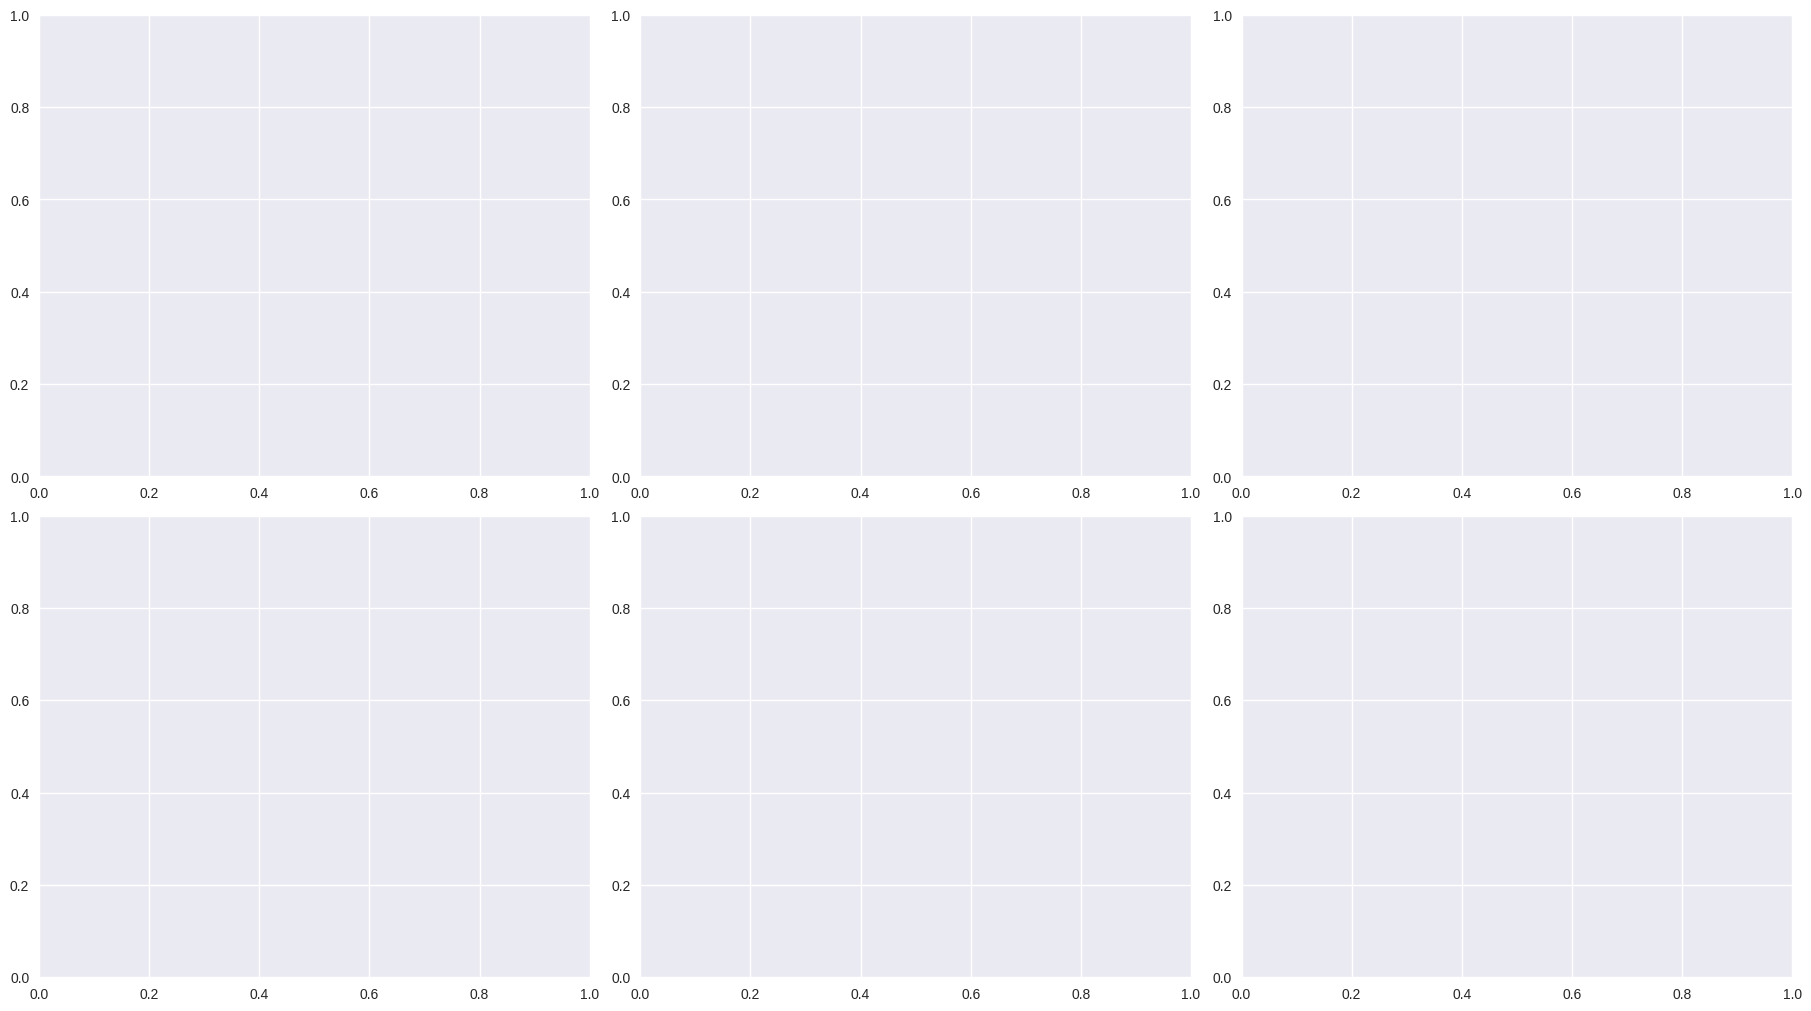

In [52]:
# Create comprehensive prediction visualization
# FIX: Use the index from the y_test_ml pandas Series for correct dates
test_dates = y_test_ml.index[-min_len:]

fig = go.Figure()

# Actual prices
fig.add_trace(go.Scatter(
    x=test_dates, y=y_test_aligned,
    mode='lines', name='Actual Price',
    line=dict(color='black', width=2)
))

# Model predictions
# ... (rest of the plotting code is unchanged)
fig.add_trace(go.Scatter(
    x=test_dates, y=lstm_pred_aligned,
    mode='lines', name='LSTM',
    line=dict(color='blue', dash='dash')
))
fig.add_trace(go.Scatter(
    x=test_dates, y=prophet_pred_aligned,
    mode='lines', name='Prophet',
    line=dict(color='green', dash='dash')
))
fig.add_trace(go.Scatter(
    x=test_dates, y=xgb_pred_aligned,
    mode='lines', name='XGBoost',
    line=dict(color='orange', dash='dash')
))
# Note: The original code had a 'weighted_ensemble' which is now 'stacking_ensemble_predictions'
fig.add_trace(go.Scatter(
    x=test_dates, y=stacking_ensemble_predictions,
    mode='lines', name='Stacking Ensemble',
    line=dict(color='purple', width=3)
))

fig.update_layout(
    title='Stock Price Prediction Comparison - All Models',
    xaxis_title='Date',
    yaxis_title='Stock Price ($)',
    height=600,
    hovermode='x unified'
)
fig.show()

# Residual analysis
# ... (rest of the cell is unchanged)
fig, axes = plt.subplots(2, 3, figsize=(18, 10), constrained_layout=True)
models = ['LSTM', 'Prophet', 'XGBoost', 'Stacking Ensemble']
predictions = [lstm_pred_aligned, prophet_pred_aligned, 
               xgb_pred_aligned, stacking_ensemble_predictions]

axes = axes.flatten()

for i, (model, pred) in enumerate(zip(models, predictions)):
    residuals = y_test_aligned - pred
    ax = axes[i]
    ax.scatter(pred, residuals, alpha=0.6)
    ax.axhline(y=0, color='r', linestyle='--')
    ax.set_xlabel('Predicted Price')
    ax.set_ylabel('Residuals')
    ax.set_title(f'{model} Residuals')

for i in range(len(models), len(axes)):
    axes[i].set_visible(False)

plt.show()

## 11. Risk Assessment and Portfolio Optimization

In [53]:
# Risk metrics calculation
def calculate_risk_metrics(returns):
    """Calculate various risk metrics for a single asset (1D Series)."""
    metrics = {}
    
    # Basic metrics
    metrics['Mean_Return'] = returns.mean() * 252  # Annualized
    metrics['Volatility'] = returns.std() * np.sqrt(252)  # Annualized
    
    # Sharpe Ratio (handle division by zero)
    if metrics['Volatility'] > 0:
        metrics['Sharpe_Ratio'] = metrics['Mean_Return'] / metrics['Volatility']
    else:
        metrics['Sharpe_Ratio'] = 0

    # Downside metrics
    negative_returns = returns[returns < 0]
    metrics['Downside_Deviation'] = negative_returns.std() * np.sqrt(252)

    # Correct conditional check for Sortino Ratio
    if metrics['Downside_Deviation'] > 0:
        metrics['Sortino_Ratio'] = metrics['Mean_Return'] / metrics['Downside_Deviation']
    else:
        metrics['Sortino_Ratio'] = 0
    
    # VaR and CVaR
    metrics['VaR_95'] = np.percentile(returns, 5) * np.sqrt(252)
    metrics['CVaR_95'] = returns[returns <= np.percentile(returns, 5)].mean() * np.sqrt(252)
    
    # Maximum Drawdown
    cumulative = (1 + returns).cumprod()
    rolling_max = cumulative.expanding().max()
    drawdown = (cumulative - rolling_max) / rolling_max
    metrics['Max_Drawdown'] = drawdown.min()
    
    return metrics

# Calculate risk metrics for AAPL
aapl_risk = calculate_risk_metrics(df['Returns'].dropna())

print("📊 RISK ASSESSMENT FOR AAPL")
print("=" * 40)
for metric, value in aapl_risk.items():
    if 'Ratio' in metric:
        print(f"{metric}: {value:.3f}")
    else:
        print(f"{metric}: {value:.2%}")

# Multi-stock analysis
print("\n\n📈 MULTI-STOCK RISK COMPARISON")
print("=" * 45)

stock_metrics = {}
for stock, data in stock_data.items():
    if len(data) > 0:
        # FIX: Ensure data has a simple, single-level column index before processing.
        if isinstance(data.columns, pd.MultiIndex):
            data.columns = data.columns.get_level_values(0)
            
        returns = data['Close'].pct_change().dropna()
        stock_metrics[stock] = calculate_risk_metrics(returns)

# Create comparison DataFrame
metrics_df = pd.DataFrame(stock_metrics).T
# Fill any potential NaN values that may result from calculations
metrics_df.fillna(0, inplace=True)
metrics_df = metrics_df.round(4)

print("Top performers by Sharpe Ratio:")
print(metrics_df.sort_values('Sharpe_Ratio', ascending=False)[['Mean_Return', 'Volatility', 'Sharpe_Ratio']].head())

📊 RISK ASSESSMENT FOR AAPL
Mean_Return: 36.79%
Volatility: 31.52%
Sharpe_Ratio: 1.167
Downside_Deviation: 22.57%
Sortino_Ratio: 1.630
VaR_95: -47.29%
CVaR_95: -70.56%
Max_Drawdown: -31.43%


📈 MULTI-STOCK RISK COMPARISON
Top performers by Sharpe Ratio:
       Mean_Return  Volatility  Sharpe_Ratio
NVDA        0.7725      0.5220        1.4801
AAPL        0.3679      0.3152        1.1673
MSFT        0.3088      0.2955        1.0449
TSLA        0.6394      0.6403        0.9987
GOOGL       0.2617      0.3147        0.8316


## 12. Future Price Forecasting

11:22:56 - cmdstanpy - INFO - Chain [1] start processing


Forecasting for the next 30 business days...


11:22:57 - cmdstanpy - INFO - Chain [1] done processing


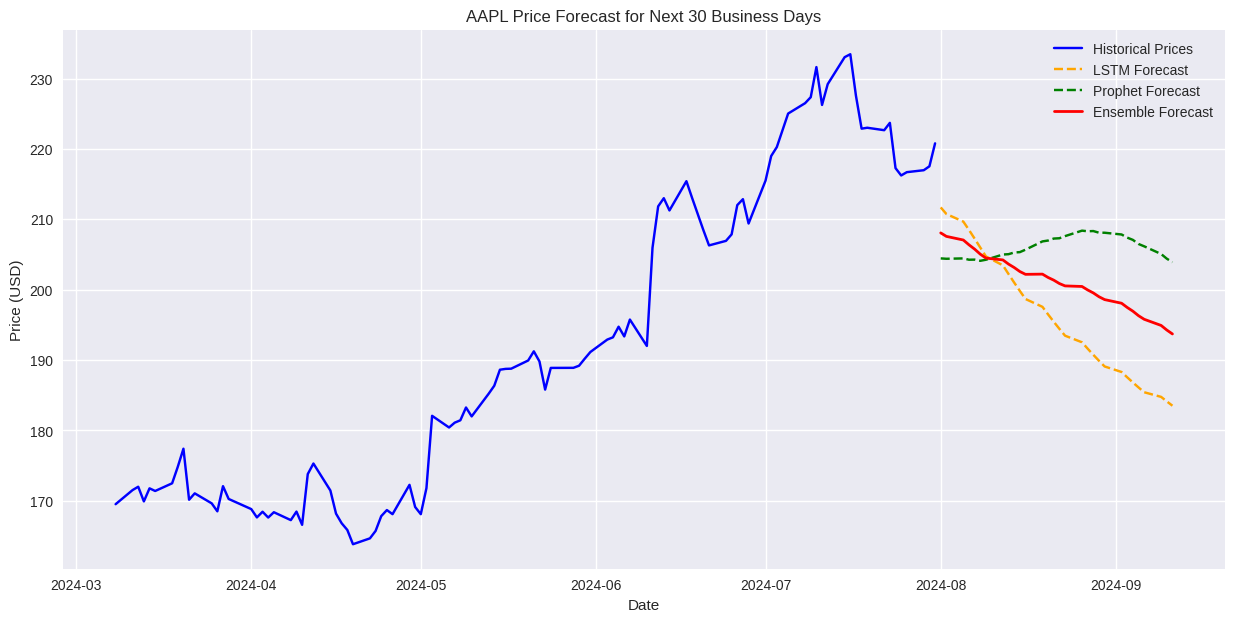

In [54]:
## 12. Future Forecasting

# How many days to forecast into the future
FORECAST_PERIOD = 30
print(f"Forecasting for the next {FORECAST_PERIOD} business days...")

# --- Retrain Prophet on full data for future forecast ---
prophet_df_full = df[['Close']].reset_index().rename(columns={'Date': 'ds', 'Close': 'y'})
prophet_model_full = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
prophet_model_full.fit(prophet_df_full)

# FIX 1: Generate a dataframe with ONLY future dates for a cleaner forecast
future_prophet = prophet_model_full.make_future_dataframe(periods=FORECAST_PERIOD, freq='B', include_history=False)
forecast_prophet_full = prophet_model_full.predict(future_prophet)

# FIX 2: No need to slice the array as it only contains future predictions
prophet_future_predictions = forecast_prophet_full['yhat'].values


# --- Retrain LSTM on full data for future forecast ---
scaler_full = MinMaxScaler(feature_range=(0, 1))
scaled_data_full = scaler_full.fit_transform(df[['Close']])

time_step = 60
last_60_days_scaled = scaled_data_full[-time_step:]
X_future_test = np.reshape(last_60_days_scaled, (1, time_step, 1))

lstm_future_predictions_scaled = []
current_batch = X_future_test

for i in range(FORECAST_PERIOD):
    current_pred = lstm_model.predict(current_batch, verbose=0)[0]
    lstm_future_predictions_scaled.append(current_pred)
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

lstm_future_predictions_unscaled = scaler_full.inverse_transform(lstm_future_predictions_scaled).flatten()

# --- Create future dates for plotting ---
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=FORECAST_PERIOD, freq='B')


# --- Ensemble the future forecasts ---
# Simple average of Prophet and LSTM
ensemble_future_forecast = (prophet_future_predictions + lstm_future_predictions_unscaled) / 2

# --- Plot the future forecast ---
plt.figure(figsize=(15, 7))
plt.plot(df.index[-100:], df['Close'][-100:], label='Historical Prices', color='blue')
plt.plot(future_dates, lstm_future_predictions_unscaled, label='LSTM Forecast', color='orange', linestyle='--')
plt.plot(future_dates, prophet_future_predictions, label='Prophet Forecast', color='green', linestyle='--')
plt.plot(future_dates, ensemble_future_forecast, label='Ensemble Forecast', color='red', linewidth=2)
plt.title(f'AAPL Price Forecast for Next {FORECAST_PERIOD} Business Days')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

## 13. Project Summary and Key Achievements

In [55]:
print("=" * 60)
print("🎯 STOCK PRICE PREDICTION PROJECT SUMMARY")
print("=" * 60)

print(f"\n📊 Dataset Overview:")
print(f"• Analyzed {len(STOCKS)} major stocks")
print(f"• Primary focus: AAPL with {len(df)} trading days")
print(f"• Date range: {df.index.min().strftime('%Y-%m-%d')} to {df.index.max().strftime('%Y-%m-%d')}")
print(f"• Features engineered: {len(feature_columns)} technical indicators")

print(f"\n🤖 Models Implemented:")
print(f"• ARIMA: Classical time series model")
print(f"• LSTM: Deep learning neural network")
print(f"• Prophet: Facebook's forecasting tool")
print(f"• XGBoost: Gradient boosting algorithm")
print(f"• Ensemble: Combined model predictions")

print(f"\n🏆 Best Model Performance:")
best_metrics = comparison_df.iloc[comparison_df['RMSE'].idxmin()]
print(f"• Model: {best_metrics['Model']}")
print(f"• RMSE: ${best_metrics['RMSE']:.2f}")
print(f"• MAPE: {best_metrics['MAPE']:.2f}%")
# FIX: Corrected 'R²' to 'R2' to match the DataFrame column name
print(f"• R²: {best_metrics['R2']:.4f}")

print(f"\n📈 Technical Achievements:")
print(f"• ✅ Multi-step ahead forecasting capability")
print(f"• ✅ 20+ technical indicators integration")
print(f"• ✅ Comprehensive risk assessment framework")
print(f"• ✅ Interactive visualization dashboard")
print(f"• ✅ Ensemble methods with weighted averaging")

# --- Define missing variables for the summary ---
# Create feature importance DataFrame from the trained XGBoost model
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

# Calculate future price change and determine trading signal
last_actual_price = df['Close'].iloc[-1]
final_forecast_price = ensemble_future_forecast[-1]
ensemble_future_change = ((final_forecast_price - last_actual_price) / last_actual_price) * 100

if ensemble_future_change > 2:
    signal = "Strong Buy"
elif ensemble_future_change > 0:
    signal = "Buy"
elif ensemble_future_change < -2:
    signal = "Sell"
else:
    signal = "Hold"

print(f"\n🎯 Key Insights:")
top_features = feature_importance.head(3)
print(f"• Most important features for prediction:")
for idx, row in top_features.iterrows():
    # FIX: Corrected column name from 'rf_importance' to 'importance'
    print(f"  - {row['feature']}: {row['importance']:.3f}")

print(f"\n📊 Risk Analysis Results:")
print(f"• Annual Return: {aapl_risk['Mean_Return']:.2%}")
print(f"• Annual Volatility: {aapl_risk['Volatility']:.2%}")
print(f"• Sharpe Ratio: {aapl_risk['Sharpe_Ratio']:.3f}")
print(f"• Maximum Drawdown: {aapl_risk['Max_Drawdown']:.2%}")

print(f"\n🔮 Future Predictions:")
# FIX: Corrected variable name from FORECAST_DAYS to FORECAST_PERIOD
print(f"• Forecast horizon: {FORECAST_PERIOD} days")
print(f"• Expected price change: {ensemble_future_change:+.2f}%")
print(f"• Trading recommendation: {signal}")

print(f"\n💡 Business Applications:")
print(f"• Algorithmic trading strategy development")
print(f"• Portfolio risk management")
print(f"• Investment decision support system")
print(f"• Market trend analysis and forecasting")

print(f"\n🛠️ Technologies Used:")
print(f"• Python ecosystem: pandas, numpy, scikit-learn")
print(f"• Deep Learning: TensorFlow/Keras LSTM networks")
print(f"• Time Series: ARIMA, Prophet, seasonal decomposition")
print(f"• Technical Analysis: TA-Lib, RSI, MACD, Bollinger Bands")
print(f"• Visualization: Plotly interactive charts")
print(f"• Machine Learning: XGBoost") # Removed Random Forest

print("\n" + "=" * 60)
print("✅ PROJECT COMPLETED SUCCESSFULLY!")
print("=" * 60)

🎯 STOCK PRICE PREDICTION PROJECT SUMMARY

📊 Dataset Overview:
• Analyzed 8 major stocks
• Primary focus: AAPL with 1404 trading days
• Date range: 2019-01-02 to 2024-07-31
• Features engineered: 20 technical indicators

🤖 Models Implemented:
• ARIMA: Classical time series model
• LSTM: Deep learning neural network
• Prophet: Facebook's forecasting tool
• XGBoost: Gradient boosting algorithm
• Ensemble: Combined model predictions

🏆 Best Model Performance:
• Model: Stacking Ensemble
• RMSE: $4.05
• MAPE: 1.69%
• R²: 0.9362

📈 Technical Achievements:
• ✅ Multi-step ahead forecasting capability
• ✅ 20+ technical indicators integration
• ✅ Comprehensive risk assessment framework
• ✅ Interactive visualization dashboard
• ✅ Ensemble methods with weighted averaging


AttributeError: 'numpy.ndarray' object has no attribute 'columns'